In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,)


この画像データのラベルは5です


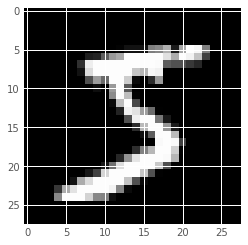

In [119]:
# MNISTデータの前処理
X = mnist.data / 255  
# 正解ラベル
y = mnist.target

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{}です".format(y[0]))


In [120]:
# DataLoderの作成

import torch
from torch.utils.data import TensorDataset, DataLoader

# データを訓練とテストのために、6:1に分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=0)

# 5-2. データのフォーマットを変換：PyTorchでの形式 = [画像数，チャネル数，高さ，幅]
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28 ,28)

y_train = y_train.astype("float64")
y_test = y_test.astype("float64")

# データをPyTorchのTensorに変換
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# データとラベルをセットにしたDatasetを作成
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# データセットのミニバッチサイズを指定した、Dataloaderを作成
loader_train = DataLoader(ds_train, batch_size=32, shuffle=True)
loader_test = DataLoader(ds_test,batch_size=32,  shuffle=False)


In [121]:
# 外部モジュールの変更を反映
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:

# 畳み込みニューラルネットワークの設定
import torch.nn as nn
import torch.nn.functional as F
from spp_layer import spatial_pyramid_pool

num_layer = 2                   # 畳み込み層の数
num_filters = [16, 32]          # 各畳み込み層のフィルタ数
mid_units = 100                 # 全結合層のユニット数

in_height = 28
in_width = 28
kernel = 3
#dropout_prob = 0.0

class SPP_Net(nn.Module):
  def __init__(self):
    super(SPP_Net, self).__init__()
    
    self.conv1 = nn.Conv2d(1, num_filters[0], 3)
    self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], 3)
    
    self.output_num = [4,2,1]
    
    self.fc1 = nn.Linear(in_features= num_filters[1]*sum([16,4,1]), out_features=mid_units)     
    #self.fc1 = nn.Linear(in_features= num_filters[1]*5*5, out_features=mid_units) 
    self.fc2 = nn.Linear(in_features=mid_units, out_features=10)
        

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    
    # 最後のpooling層のみSPP層に変更
    x = self.conv2(x)
    x = F.relu(spatial_pyramid_pool(self,x,self.output_num))

    x = x.view(x.size(0),-1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

spp_model = SPP_Net()
print(spp_model)

SPP_Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=672, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [123]:
# 畳み込みニューラルネットワークの設定
import torch.nn as nn
import torch.nn.functional as F

num_layer = 2                   # 畳み込み層の数
num_filters = [16, 32]          # 各畳み込み層のフィルタ数
mid_units = 100                 # 全結合層のユニット数

in_height = 28
in_width = 28
kernel = 3
#dropout_prob = 0.0

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(1, num_filters[0], 3)
    self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], 3)
    
    self.output_num = [4,2,1]
    
    #self.fc1 = nn.Linear(in_features= num_filters[1]*11*11, out_features=mid_units)     
    self.fc1 = nn.Linear(in_features= num_filters[1]*5*5, out_features=mid_units) 
    self.fc2 = nn.Linear(in_features=mid_units, out_features=10)
        

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
            
    #print(x.size())
    
    x = x.view(x.size(0),-1)
    #print(x.size())
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [124]:
# 4. 誤差関数と最適化手法の設定
 
from torch import optim
 
# 誤差関数の設定
loss_fn = nn.CrossEntropyLoss()  # 変数名にはcriterionも使われる
 
# 重みを学習する際の最適化手法の選択
optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer_spp = optim.Adam(spp_model.parameters(), lr=0.01)

In [125]:
# 5. 学習と推論の設定
# 学習1回でやることを定義します
# Chainerのtraining.Trainer()に対応するものはない

from torch.autograd import Variable

def train(epoch, pooling_method):
    if pooling_method == "SPP":
        spp_model.train()
        # ネットワークを学習モードに切り替える
        # データローダーから1ミニバッチずつ取り出して計算する
        for data, target in loader_train:
            data, target = Variable(data), Variable(target)  # 微分可能に変換
            optimizer_spp.zero_grad()  # 一度計算された勾配結果を0にリセット
            output = spp_model(data)  # 入力dataをinputし、出力を求める
            loss = loss_fn(output, target)  # 出力と訓練データの正解との誤差を求める
            loss.backward()  # 誤差のバックプロパゲーションを求める
            optimizer_spp.step()  # バックプロパゲーションの値で重みを更新する
    
    else:
        model.train()
        for data, target in loader_train:
            data, target = Variable(data), Variable(target)  # 微分可能に変換
            optimizer.zero_grad()  # 一度計算された勾配結果を0にリセット
            output = model(data)    
            loss = loss_fn(output, target)  # 出力と訓練データの正解との誤差を求める
            loss.backward()  # 誤差のバックプロパゲーションを求める
            optimizer.step()  # バックプロパゲーションの値で重みを更新する

    print("epoch{}：終了\n".format(epoch))
    return loss

In [126]:
def test(pooling_method):
    # ネットワークを推論モードに切り替える
    if pooling_method == "SPP":
        spp_model.eval()
    else:
        model.eval()
        
    correct = 0
    # データローダーから1ミニバッチずつ取り出して計算する
    for data, target in loader_test:
        data, target = Variable(data), Variable(target)
        if pooling_method == "SPP":
            output = spp_model(data)  
        else:
            output = model(data)    
        
        # 推論する
        pred = output.data.max(1, keepdim=True)[1]
        # 出力ラベルを求める
        correct += pred.eq(target.data.view_as(pred)).sum()
        loss = loss_fn(output, target) 
        # 正解と一緒だったらカウントアップ
        # 正解率を出力
        data_num = len(loader_test.dataset)
        
    # データの総数
    print('\nテストデータの正解率: {}/{} ({:.0f}%)\n'.format(correct, data_num, 100. * correct / data_num))
    return loss

In [127]:
# 学習なしにテストデータで推論
test('MAX')



テストデータの正解率: 982/10000 (10%)



tensor(2.3001, grad_fn=<NllLossBackward>)

epoch0：終了


テストデータの正解率: 9660/10000 (97%)

epoch1：終了


テストデータの正解率: 9758/10000 (98%)

epoch2：終了


テストデータの正解率: 9787/10000 (98%)

epoch3：終了


テストデータの正解率: 9744/10000 (97%)

epoch4：終了


テストデータの正解率: 9761/10000 (98%)

epoch5：終了


テストデータの正解率: 9752/10000 (98%)

epoch6：終了


テストデータの正解率: 9802/10000 (98%)

epoch7：終了


テストデータの正解率: 9806/10000 (98%)

epoch8：終了


テストデータの正解率: 9793/10000 (98%)

epoch9：終了


テストデータの正解率: 9767/10000 (98%)

epoch10：終了


テストデータの正解率: 9778/10000 (98%)

epoch11：終了


テストデータの正解率: 9763/10000 (98%)

epoch12：終了


テストデータの正解率: 9799/10000 (98%)

epoch13：終了


テストデータの正解率: 9785/10000 (98%)

epoch14：終了


テストデータの正解率: 9775/10000 (98%)

epoch15：終了


テストデータの正解率: 9768/10000 (98%)

epoch16：終了


テストデータの正解率: 9771/10000 (98%)

epoch17：終了


テストデータの正解率: 9753/10000 (98%)

epoch18：終了


テストデータの正解率: 9713/10000 (97%)

epoch19：終了


テストデータの正解率: 9773/10000 (98%)

epoch20：終了


テストデータの正解率: 9779/10000 (98%)

epoch21：終了


テストデータの正解率: 9748/10000 (97%)

epoch22：終了


テストデータの正解率: 9796/10000 (98%)

epoch23：終了


テストデータの正

epoch91：終了


テストデータの正解率: 9724/10000 (97%)

epoch92：終了


テストデータの正解率: 9748/10000 (97%)

epoch93：終了


テストデータの正解率: 9635/10000 (96%)

epoch94：終了


テストデータの正解率: 9714/10000 (97%)

epoch95：終了


テストデータの正解率: 9659/10000 (97%)

epoch96：終了


テストデータの正解率: 9578/10000 (96%)

epoch97：終了


テストデータの正解率: 9690/10000 (97%)

epoch98：終了


テストデータの正解率: 9667/10000 (97%)

epoch99：終了


テストデータの正解率: 9663/10000 (97%)



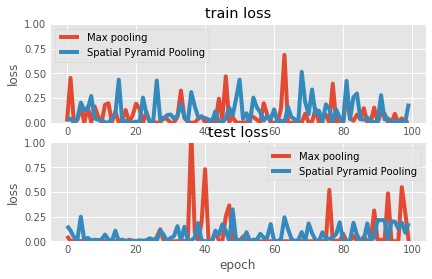

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_loss_list = []
test_loss_list = []
train_loss_list_spp = []
test_loss_list_spp = []

pooling_method = ['MAX','SPP']

num_epochs = 100

for epoch in range(num_epochs):
    train_loss = train(epoch, pooling_method[0])
    test_loss = test(pooling_method[0])
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
for epoch in range(num_epochs):
    train_loss = train(epoch, pooling_method[1])
    test_loss = test(pooling_method[1])
    
    train_loss_list_spp.append(train_loss)
    test_loss_list_spp.append(test_loss)
    

# save the training model
np.save('train_loss_list.npy', np.array(train_loss_list))
np.save('test_loss_list.npy', np.array(test_loss_list))
np.save('train_loss_list_spp.npy', np.array(train_loss_list))
np.save('test_loss_list_spp.npy', np.array(test_loss_list))
torch.save(model.state_dict(), 'vae.pth')
torch.save(spp_model.state_dict(), 'vae_spp.pth')
    
#loss_list = np.load('{}/loss_list.npy'.format(out_dir))
plt.style.use('ggplot')

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, label="Max pooling")
plt.plot(train_loss_list_spp, label="Spatial Pyramid Pooling")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim([0,1])
plt.title("train loss")

plt.subplot(2, 1, 2)
plt.plot(test_loss_list, label="Max pooling")
plt.plot(test_loss_list_spp, label="Spatial Pyramid Pooling")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim([0,1])
plt.title("test loss")

plt.show()




In [129]:
# max-pooling
# 60000のデータに3エポック学習を実行する
for epoch in range(3):
    train(epoch,"SPP")
    test("SPP")

epoch0：終了


テストデータの正解率: 9703/10000 (97%)

epoch1：終了


テストデータの正解率: 9651/10000 (97%)

epoch2：終了


テストデータの正解率: 9662/10000 (97%)



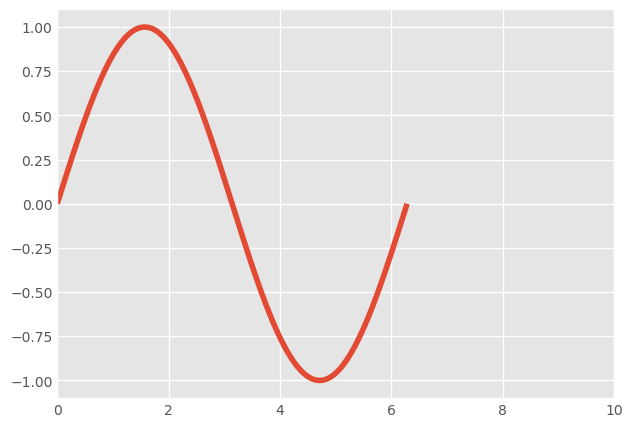

In [115]:
import math
plt.style.use('ggplot')
x = np.linspace(0, 2*math.pi, 100)  #0から2πまでの範囲を100分割したnumpy配列
y = np.sin(x)

plt.plot(x,y)
plt.xlim([0,10])
plt.show()